<a href="https://colab.research.google.com/github/Mayanzev/Telecom/blob/main/lab6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os

if not os.path.exists('thinkdsp.py'):
    !wget https://github.com/AllenDowney/ThinkDSP/raw/master/code/thinkdsp.py
import numpy as np
import matplotlib.pyplot as plt

from thinkdsp import decorate

--2024-04-06 20:43:48--  https://github.com/AllenDowney/ThinkDSP/raw/master/code/thinkdsp.py
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/AllenDowney/ThinkDSP/master/code/thinkdsp.py [following]
--2024-04-06 20:43:48--  https://raw.githubusercontent.com/AllenDowney/ThinkDSP/master/code/thinkdsp.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 48574 (47K) [text/plain]
Saving to: ‘thinkdsp.py’

thinkdsp.py         100%[===================>]  47.44K  --.-KB/s    in 0.01s   

2024-04-06 20:43:48 (4.65 MB/s) - ‘thinkdsp.py’ saved [48574/48574]



# **Упражнение 6.1**
В этой главе утверждается, что analyze1 требует времени пропорционально n^3, а analyze2 - пропорционально n^2. Убедитесь в этом, запуская их с несколькими разными массивами и засекая время работы. В блокнотах Jypyter можно использовать "волшебную команду" %timeit.

Если печатать зависимость времени работы от размера на логарифмической шкале, то получится прямая линия с уклоном 3 для analyze1 и с уклоном 2 для analyze2.
Также стоит поупражняться с dct_iv и scipy.fftpack.dct.

In [3]:
from thinkdsp import UncorrelatedGaussianNoise

signal = UncorrelatedGaussianNoise()
noise = signal.make_wave(duration=1.0, framerate=16384)
noise.ys.shape

(16384,)

Функция принимает массив результатов эксперимента по определению времени, строит график результатов и подгоняет прямую линию.

In [4]:
from scipy.stats import linregress

loglog = dict(xscale='log', yscale='log')

def plot_bests(ns, bests):
    plt.plot(ns, bests)
    decorate(**loglog)

    x = np.log(ns)
    y = np.log(bests)
    t = linregress(x,y)
    slope = t[0]

    return slope

In [5]:
PI2 = np.pi * 2

def analyze1(ys, fs, ts):
    args = np.outer(ts, fs)
    M = np.cos(PI2 * args)
    amps = np.linalg.solve(M, ys)
    return amps

In [6]:
def run_speed_test(ns, func):
    results = []
    for N in ns:
        print(N)
        ts = (0.5 + np.arange(N)) / N
        freqs = (0.5 + np.arange(N)) / 2
        ys = noise.ys[:N]
        result = %timeit -r1 -o func(ys, freqs, ts)
        results.append(result)

    bests = [result.best for result in results]
    return bests

Результаты для analyze1:

In [7]:
ns = 2 ** np.arange(6, 13)
ns

array([  64,  128,  256,  512, 1024, 2048, 4096])

64
327 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1000 loops each)
128
1.05 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1000 loops each)
256
4.18 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
512
27.2 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
1024
102 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
2048
740 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
4096
2.54 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


2.2251823368961157

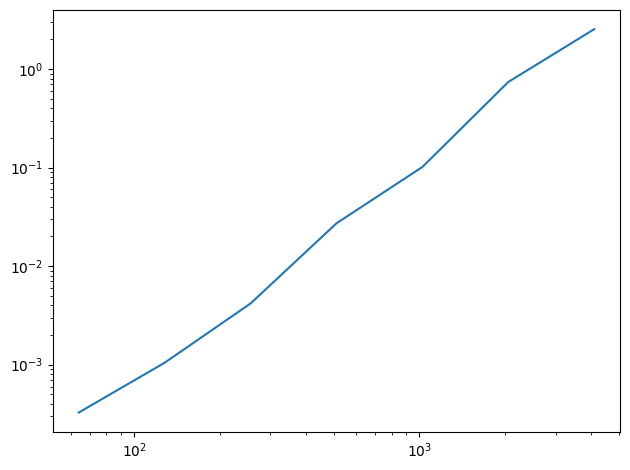

In [8]:
bests = run_speed_test(ns, analyze1)
plot_bests(ns, bests)

Угол наклона близок к 2, а не к 3, как ожидалось. Возможно, производительность np.linalg.solve почти квадратичная в этом диапазоне размеров массива.

Результаты для analyze2:

In [9]:
def analyze2(ys, fs, ts):
    args = np.outer(ts, fs)
    M = np.cos(PI2 * args)
    amps = np.dot(M, ys) / 2
    return amps

64
107 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 10000 loops each)
128
616 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1000 loops each)
256
2.34 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
512
8.86 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)
1024
45.4 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
2048
219 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)
4096
476 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


2.056493291730658

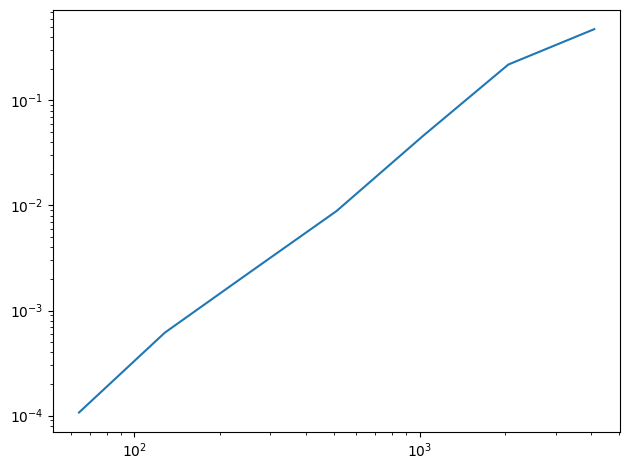

In [10]:
bests2 = run_speed_test(ns, analyze2)
plot_bests(ns, bests2)

Результаты для analyze2, как и ожидалось, укладываются в прямую линию с углом наклона, близким к 2.

Результаты для dct_iv и scipy.fftpack.dct:

In [11]:
import scipy.fftpack

def scipy_dct(ys, freqs, ts):
    return scipy.fftpack.dct(ys, type=3)

64
7.39 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 100000 loops each)
128
6.82 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 100000 loops each)
256
8.44 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 100000 loops each)
512
9.65 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 100000 loops each)
1024
13.8 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 100000 loops each)
2048
40.7 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 10000 loops each)
4096
71.5 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 10000 loops each)


0.560330195189787

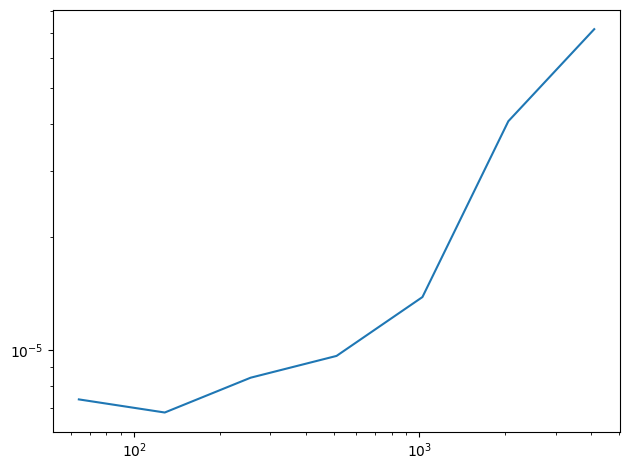

In [14]:
bests3 = run_speed_test(ns, scipy_dct)
plot_bests(ns, bests3)

Угол наклона у dct нелинейный. Линия изогнута, что означает, что либо мы еще не видели асимптотического поведения, либо асимптотическое поведение не является простой экспонентой nlogn.

# **Упражнение 6.2**
Одно из основных применений ДКП - это сжатие звука и изображений. В простейшей форме ДКП при сжатии работает следующим образом:

1. Разбивает длинный сигнал на сегменты.
2. Вычисляет ДКП каждого сегмента.
3. Определяет частотные компоненты с амплитудой, что их не слышно, и удаляет их, сохраняя только оставшиеся частоты и амплитуды.
4. При воспроизведении сигнала загружает частоты и амплитуды каждого сегмента и применяет обратное ДКП.

Реализуйте версию алгоритма и примените его для записи музыки или речи. Сколько компонент можно удалить до того, как разница станет заметной?

В качестве примера я использую запись саксофона из прошлой работы:

In [15]:
if not os.path.exists('100475__iluppai__saxophone-weep.wav'):
    !wget https://github.com/AllenDowney/ThinkDSP/raw/master/code/100475__iluppai__saxophone-weep.wav

--2024-04-06 20:47:32--  https://github.com/AllenDowney/ThinkDSP/raw/master/code/100475__iluppai__saxophone-weep.wav
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/AllenDowney/ThinkDSP/master/code/100475__iluppai__saxophone-weep.wav [following]
--2024-04-06 20:47:33--  https://raw.githubusercontent.com/AllenDowney/ThinkDSP/master/code/100475__iluppai__saxophone-weep.wav
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2071600 (2.0M) [audio/wav]
Saving to: ‘100475__iluppai__saxophone-weep.wav’

100475__iluppai__sa 100%[===================>]   1.98M  --.-KB/s    in 0.06s   

2024-04-06 20:47:33 (3

In [16]:
from thinkdsp import read_wave

wave = read_wave('100475__iluppai__saxophone-weep.wav')
wave.make_audio()

Снова выберем небольшой сегмент.

In [17]:
segment = wave.segment(start=1.2, duration=0.5)
segment.normalize()
segment.make_audio()

ДКП сегмента.

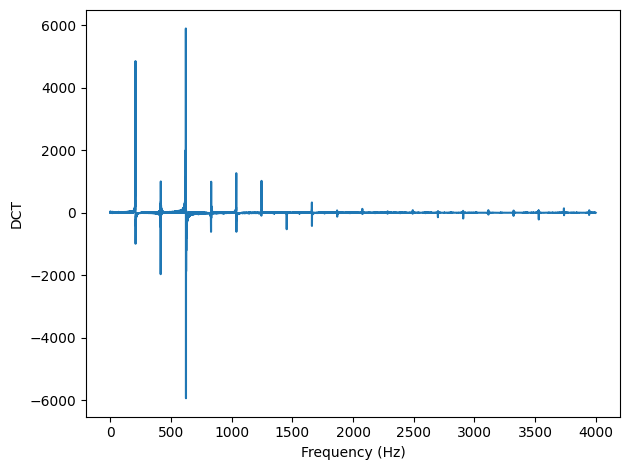

In [18]:
seg_dct = segment.make_dct()
seg_dct.plot(high=4000)
decorate(xlabel='Frequency (Hz)', ylabel='DCT')

Можно увидеть несколько гармоник со значительной амплитудой, а многие записи близки к нулю.

Уменьшим громкость некоторых звуков до 0.

In [19]:
def compress(dct, thresh=1):
    count = 0
    for i, amp in enumerate(dct.amps):
        if np.abs(amp) < thresh:
            dct.hs[i] = 0
            count += 1

    n = len(dct.amps)
    print(count, n, 100 * count / n, sep='\t')

20457	22050	92.77551020408163


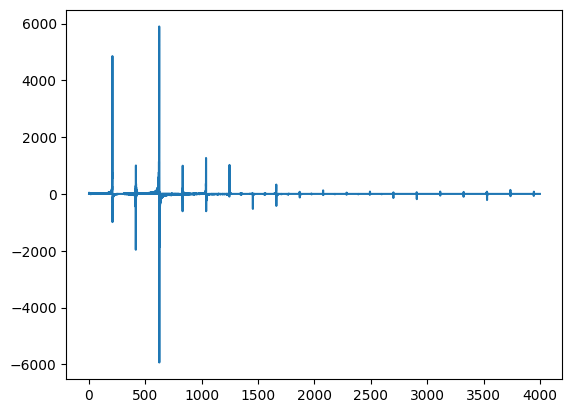

In [20]:
seg_dct = segment.make_dct()
compress(seg_dct, thresh=10)
seg_dct.plot(high=4000)

Можем прослушать результат изменений.

In [21]:
seg2 = seg_dct.make_wave()
seg2.make_audio()

Если разница и есть, то она минимальна, мне кажется, что почти неразличима.

Чтобы сжать более длинный сегмент, мы можем сделать спектрограмму ДКП.

In [22]:
from thinkdsp import Spectrogram

def make_dct_spectrogram(wave, seg_length):
    window = np.hamming(seg_length)
    i, j = 0, seg_length
    step = seg_length // 2

    spec_map = {}

    while j < len(wave.ys):
        segment = wave.slice(i, j)
        segment.window(window)

        t = (segment.start + segment.end) / 2
        spec_map[t] = segment.make_dct()

        i += step
        j += step

    return Spectrogram(spec_map, seg_length)

Применим сжатие к каждому сегменту.

In [23]:
spectro = make_dct_spectrogram(wave, seg_length=1024)
for t, dct in sorted(spectro.spec_map.items()):
    compress(dct, thresh=0.2)

1018	1024	99.4140625
1016	1024	99.21875
1014	1024	99.0234375
1017	1024	99.31640625
1016	1024	99.21875
1017	1024	99.31640625
1016	1024	99.21875
1020	1024	99.609375
1014	1024	99.0234375
1005	1024	98.14453125
1009	1024	98.53515625
1015	1024	99.12109375
1015	1024	99.12109375
1016	1024	99.21875
1016	1024	99.21875
1015	1024	99.12109375
1017	1024	99.31640625
1020	1024	99.609375
1013	1024	98.92578125
1017	1024	99.31640625
1013	1024	98.92578125
1017	1024	99.31640625
1018	1024	99.4140625
1015	1024	99.12109375
1013	1024	98.92578125
794	1024	77.5390625
785	1024	76.66015625
955	1024	93.26171875
995	1024	97.16796875
992	1024	96.875
976	1024	95.3125
925	1024	90.33203125
802	1024	78.3203125
836	1024	81.640625
850	1024	83.0078125
882	1024	86.1328125
883	1024	86.23046875
891	1024	87.01171875
901	1024	87.98828125
902	1024	88.0859375
900	1024	87.890625
900	1024	87.890625
894	1024	87.3046875
904	1024	88.28125
901	1024	87.98828125
915	1024	89.35546875
913	1024	89.16015625
899	1024	87.79296875
905	1024	88.37

Воспроизведем, что получилось.

In [24]:
wave2 = spectro.make_wave()
wave2.make_audio()

Для удобства выведем оригинал.

In [22]:
wave.make_audio()

Сигнал после сжатия все равно очень похож на оригинал, возможно, если изменять параметр thresh, то эффект сжатия можно будет услышать более явно.

# **Упражнение 6.3**
В репозитории этой книги есть блокнот Jupyter под названием phase.ipynb в котором исследуется влияние фазы на восприятие звука. Прочтите этот блокнот и "погоняйте" примеры. Выберите иной сегмент звука и повторите эксперименты. Можно ли найти некие общие соотношения в фазовой структуре звука и его восприятии?

Можно воспользоваться уже загруженным аудио.

In [25]:
segment = wave.segment(start=0.5, duration=1.5)
segment.make_audio()

In [26]:
def plot_angle(spectrum, thresh=1):
    angles = spectrum.angles
    angles[spectrum.amps < thresh] = np.nan
    plt.plot(spectrum.fs, angles, 'x')
    decorate(xlabel='Frequency (Hz)',
             ylabel='Phase (radian)')

In [27]:
def plot_three(spectrum, thresh=1):
    plt.figure(figsize=(10, 4))
    plt.subplot(1,3,1)
    spectrum.plot()
    plt.subplot(1,3,2)
    plot_angle(spectrum, thresh=thresh)
    plt.subplot(1,3,3)
    wave = spectrum.make_wave()
    wave.unbias()
    wave.normalize()
    wave.segment(duration=0.01).plot()
    display(wave.make_audio())

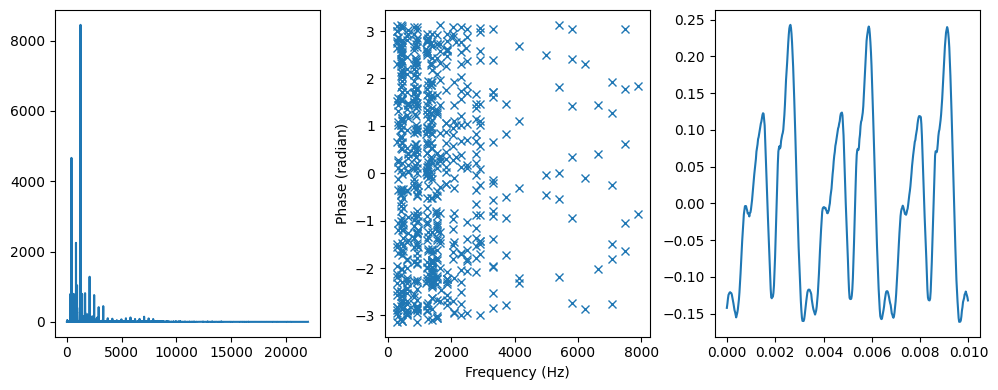

In [28]:
spectrum = segment.make_spectrum()
plot_three(spectrum, thresh=50)

Попробуем установить все углы на ноль.

In [29]:
def zero_angle(spectrum):
    res = spectrum.copy()
    res.hs = res.amps
    return res

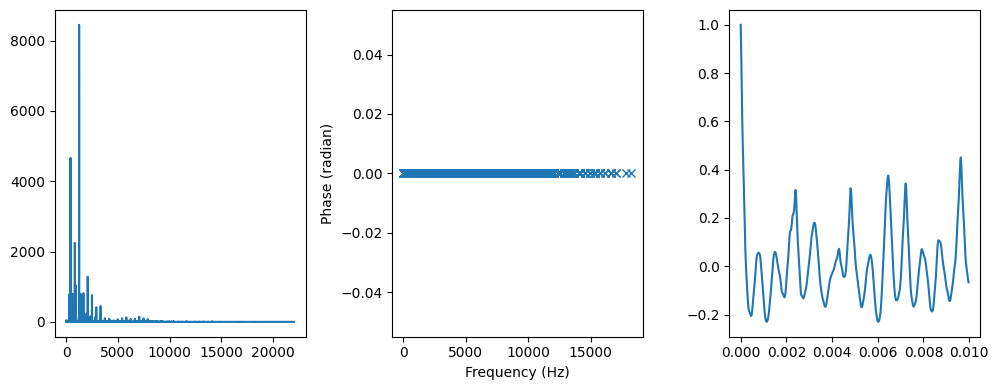

In [30]:
spectrum2 = zero_angle(spectrum)
plot_three(spectrum2)

Здесь углы повернуты уже на 1 радиан:

In [31]:
def rotate_angle(spectrum, offset):
    res = spectrum.copy()
    res.hs *= np.exp(1j * offset)
    return res

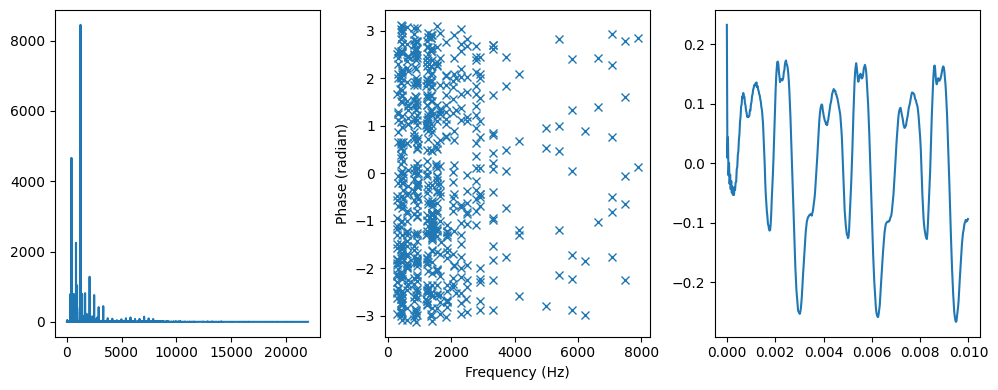

In [32]:
spectrum3 = rotate_angle(spectrum, 1)
plot_three(spectrum3, thresh=50)

Посмотрим, что будет при случайном изменении углов.

In [33]:
def random_angle(spectrum):
    res = spectrum.copy()
    angles = np.random.uniform(0, np.pi*2, len(spectrum))
    res.hs *= np.exp(1j * angles)
    return res

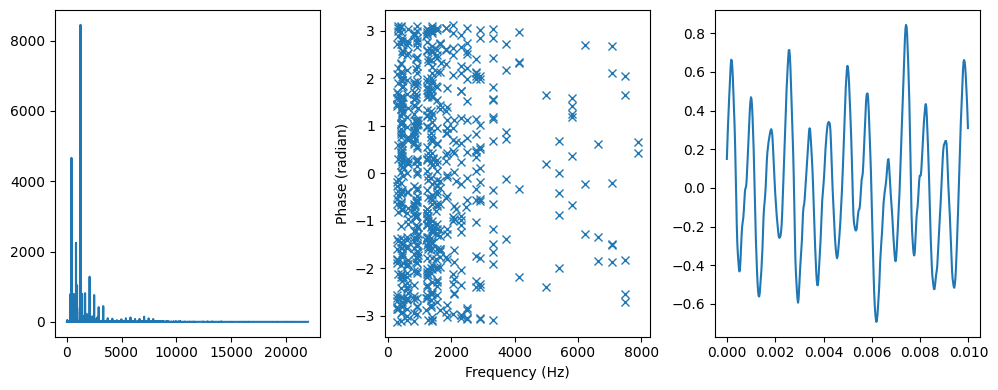

In [34]:
spectrum4 = random_angle(spectrum)
plot_three(spectrum4, thresh=50)

Разница слышима во всех трех вариантах, звук чувствителен к изменению фазовой структуры.